In [1]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [2]:
!apt-get install -y fonts-nanum
!rm -rf /root/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = font_name

## 1. load model and data

In [3]:
import sys
sys.path.append("/content/drive/MyDrive/project/src")

In [4]:
import os
import json
import pandas as pd

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.tools.utils import make_mapping
from src.dataset import RelationDataset
from src.model import RelationClassifier

import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [5]:
train_data = pd.read_csv("data/train.csv")

In [6]:
valid_data = pd.read_csv("data/valid_data.csv")

In [105]:
model_dir = "models"
model_name = "best_model_20241224_064156_601479"
valid_file = "data/valid_data.csv"

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
model_config_file = os.path.join(model_dir, model_name, "best_model_config.json")
with open(model_config_file, "r") as f:
    model_config = json.load(f)

label2id, id2label = make_mapping(model_config["label2id_path"], model_config["id2label_path"])
num_labels = len(label2id)

In [108]:
train_dist = train_data["label"].value_counts().sort_values(key=lambda x: x.index.map(label2id), ascending=True).values.tolist()

In [109]:
rare_indices = [label2id[i] for i in valid_data["label"].value_counts()[-5:].index.tolist()]

In [110]:
valid_dataset = RelationDataset(valid_file, model_config["model_name_or_path"], model_config["max_length"],
                                    label2id, use_entity_markers=model_config["use_entity_markers"],
                                    use_entity_types=model_config["use_entity_types"], use_span_pooling=model_config["use_span_pooling"],
                                    inference=False)
valid_loader = DataLoader(valid_dataset, batch_size=model_config["batch_size"], shuffle=False)


In [111]:
model = RelationClassifier(model_config["model_name_or_path"], len(label2id), model_config["dropout"],
                               len(valid_dataset.tokenizer), model_config["use_span_pooling"], model_config["use_attention_pooling"])
model.load_state_dict(torch.load(os.path.join(model_config["best_checkpoint_path"],
                                                              "pytorch_model.bin")))
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-111-6ecd911dee8e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

RelationClassifier(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32004, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

## 2. model evaluation

In [112]:
model.eval()

all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for batch in tqdm(valid_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        batch.pop("id")
        labels = batch.pop("labels")

        logits = model(**batch)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

100%|██████████| 406/406 [00:50<00:00,  8.08it/s]


In [113]:
old_preds = all_preds
old_probs = all_probs

## 3. Result Analysis

### 3.1 recall with label distribution

In [48]:
def plot_class_recall_with_label_dist(y_true, y_pred, label_names, train_labels, top_n_low_dist=5):

    num_classes = len(label_names)
    recalls = recall_score(y_true, y_pred, average=None, labels=range(num_classes))

    train_df = pd.DataFrame({"train_label": train_labels})
    train_counts = train_df["train_label"].value_counts()
    total_train = train_counts.sum()
    train_dist = train_counts / total_train

    train_ratio_list = []
    for label in label_names:
        train_ratio_list.append(train_dist[label] if label in train_dist.index else 0.0)

    idx = np.arange(num_classes)

    plt.figure(figsize=(10,6))

    plt.barh(idx + 0.2, recalls, height=0.4, color='skyblue', label='Recall')
    plt.barh(idx - 0.2, train_ratio_list, height=0.4, color='orange', label='Train Dist(%)')

    plt.yticks(idx, label_names)
    plt.xlabel("Value (Recall or Train distribution)")
    plt.title("Class-wise Recall vs. Train Label Distribution")
    plt.legend()

    plt.axvline(0.01, color='red', linestyle='--', label="Recall=10% boundary")

    for i, (r, d) in enumerate(zip(recalls, train_ratio_list)):
        plt.text(r + 0.01, i + 0.2, f"{r*100:.1f}%", va='center', color='blue')
        plt.text(d + 0.01, i - 0.2, f"{d*100:.1f}%", va='center', color='orange')

    plt.tight_layout()
    plt.show()

    all_class_indices = list(range(num_classes))
    all_class_indices.sort(key=lambda i: train_ratio_list[i])
    lowest_idx = all_class_indices[:top_n_low_dist]  # 하위 n개

    low_dist_recalls = [recalls[i] for i in lowest_idx]
    mean_low_dist_recall = np.mean(low_dist_recalls)

    print(f"=== 하위 {top_n_low_dist}개(Train 분포가 가장 적은) 클래스 리스트 ===")
    for i in lowest_idx:
        class_name = label_names[i]
        dist_val = train_ratio_list[i]*100
        r_val = recalls[i]*100
        print(f"  {class_name}: TrainDist={dist_val:.2f}%, Recall={r_val:.2f}%")

    print(f"\n하위 {top_n_low_dist}개 클래스들의 평균 Recall: {mean_low_dist_recall*100:.2f}%")

    low_recall = [(label_names[i], recalls[i]) for i in range(num_classes) if recalls[i] < 0.1]
    if low_recall:
        print("\nClasses with recall < 10%:")
        for c, val in low_recall:
            print(f"  {c}: {val*100:.2f}% recall")

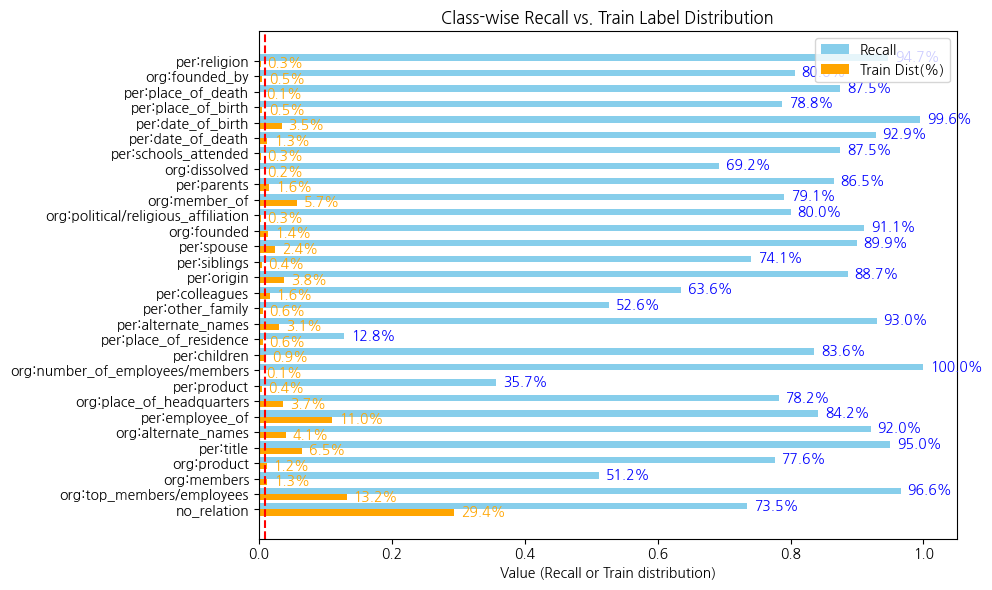

=== 하위 5개(Train 분포가 가장 적은) 클래스 리스트 ===
  per:place_of_death: TrainDist=0.12%, Recall=87.50%
  org:number_of_employees/members: TrainDist=0.15%, Recall=100.00%
  org:dissolved: TrainDist=0.20%, Recall=69.23%
  per:schools_attended: TrainDist=0.25%, Recall=87.50%
  per:religion: TrainDist=0.30%, Recall=94.74%

하위 5개 클래스들의 평균 Recall: 87.79%


In [49]:
plot_class_recall_with_label_dist(all_labels, new_preds, list(label2id.keys()), train_data["label"].tolist(), top_n_low_dist=5)

### 3.2 predicted label distribution

In [50]:
def plot_predicted_label_distribution(y_pred, label_names):
    import pandas as pd
    import matplotlib.pyplot as plt

    df_pred = pd.DataFrame({"pred_label_idx": y_pred})
    df_pred["pred_label"] = df_pred["pred_label_idx"].apply(lambda x: label_names[x])

    label_counts = df_pred["pred_label"].value_counts()
    total = label_counts.sum()
    label_percent = (label_counts / total) * 100

    plt.figure(figsize=(7,5))
    label_percent.plot(kind="bar", color="green")
    plt.title("Predicted Label Distribution (%)")
    plt.xlabel("Label")
    plt.ylabel("Percentage")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("Predicted Label (%) distribution:")
    for label, pct in label_percent.items():
        print(f"  {label}: {pct:.2f}%")

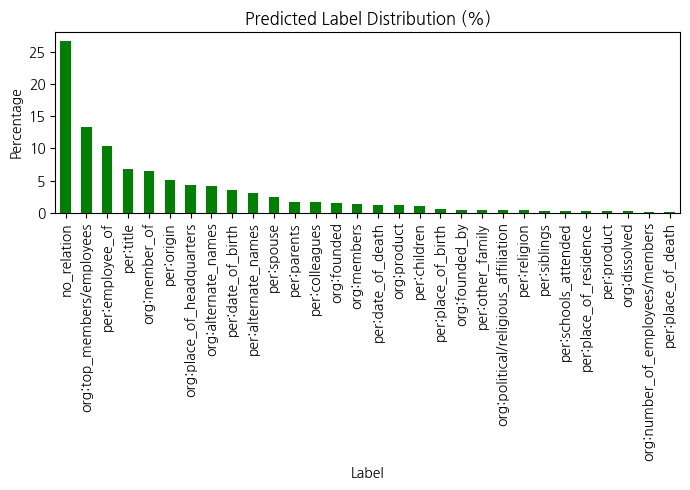

Predicted Label (%) distribution:
  no_relation: 26.76%
  org:top_members/employees: 13.40%
  per:employee_of: 10.39%
  per:title: 6.87%
  org:member_of: 6.50%
  per:origin: 5.08%
  org:place_of_headquarters: 4.33%
  org:alternate_names: 4.17%
  per:date_of_birth: 3.57%
  per:alternate_names: 3.03%
  per:spouse: 2.46%
  per:parents: 1.69%
  per:colleagues: 1.63%
  org:founded: 1.56%
  org:members: 1.37%
  per:date_of_death: 1.25%
  org:product: 1.15%
  per:children: 0.95%
  per:place_of_birth: 0.54%
  org:founded_by: 0.46%
  per:other_family: 0.43%
  org:political/religious_affiliation: 0.42%
  per:religion: 0.38%
  per:siblings: 0.32%
  per:schools_attended: 0.31%
  per:place_of_residence: 0.23%
  per:product: 0.20%
  org:dissolved: 0.20%
  org:number_of_employees/members: 0.17%
  per:place_of_death: 0.15%


In [51]:
plot_predicted_label_distribution(new_preds, list(label2id.keys()))

### 3.3 no_relation 확률 분포 정도 비교

In [53]:
def plot_no_relation_probability(old_probs, new_probs, sample_size=10000, no_rel_idx=None):


    if old_probs.ndim == 2:
        if no_rel_idx is None:
            raise ValueError("old_probs가 2차원인 경우 no_rel_idx를 지정해 주세요.")
        old_probs = old_probs[:, no_rel_idx]

    if new_probs.ndim == 2:
        if no_rel_idx is None:
            raise ValueError("new_probs가 2차원인 경우 no_rel_idx를 지정해 주세요.")
        new_probs = new_probs[:, no_rel_idx]

    if len(old_probs) > sample_size:
        idx = np.random.choice(len(old_probs), size=sample_size, replace=False)
        old_probs = old_probs[idx]

    if len(new_probs) > sample_size:
        idx = np.random.choice(len(new_probs), size=sample_size, replace=False)
        new_probs = new_probs[idx]

    plt.figure(figsize=(8, 5))
    sns.kdeplot(old_probs, shade=True, color='red', label="Old Model no_relation prob")
    sns.kdeplot(new_probs, shade=True, color='blue', label="New Model no_relation prob")
    plt.title("Distribution of no_relation Probability")
    plt.xlabel("P(no_relation)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

<ipython-input-53-c37b314f9553>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(old_probs, shade=True, color='red', label="Old Model no_relation prob")
<ipython-input-53-c37b314f9553>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(new_probs, shade=True, color='blue', label="New Model no_relation prob")
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


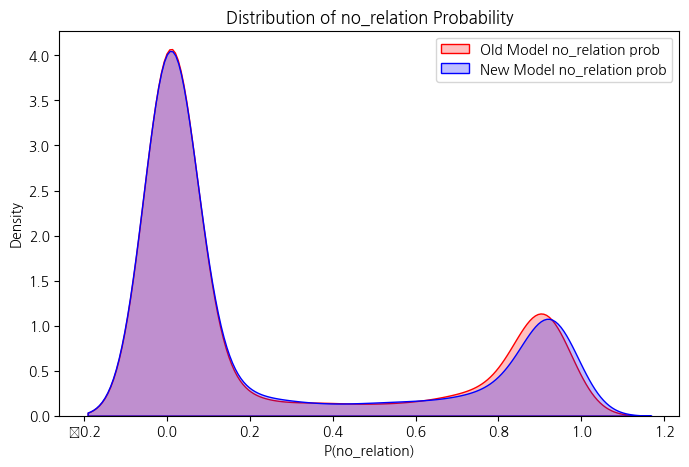

In [114]:
plot_no_relation_probability(np.array(old_probs), np.array(new_probs), sample_size=100000, no_rel_idx=0)

### 3.4 precision, recall 비교

In [73]:
def compare_precision_recall_per_class(
    y_true, y_pred_old, y_pred_new, label_names,
    rare_class_indices=None
):

    num_classes = len(label_names)

    # precision per class
    prec_old = precision_score(y_true, y_pred_old, average=None, labels=range(num_classes))
    prec_new = precision_score(y_true, y_pred_new, average=None, labels=range(num_classes))

    # recall per class
    rec_old = recall_score(y_true, y_pred_old, average=None, labels=range(num_classes))
    rec_new = recall_score(y_true, y_pred_new, average=None, labels=range(num_classes))


    idx = np.arange(num_classes)

    fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    ax1, ax2 = axes

    width = 0.35

    # (1) Precision bar chart
    ax1.bar(idx - width/2, prec_old, width=width, label="old Precision", color="orange")
    ax1.bar(idx + width/2, prec_new, width=width, label="new Precision", color="green")
    ax1.set_ylabel("Precision")
    ax1.set_title("Per-class Precision (Old vs New)")
    ax1.legend()
    ax1.set_ylim(0,1.05)

    # (2) Recall bar chart
    ax2.bar(idx - width/2, rec_old, width=width, label="old Recall", color="skyblue")
    ax2.bar(idx + width/2, rec_new, width=width, label="new Recall", color="purple")
    ax2.set_ylabel("Recall")
    ax2.set_title("Per-class Recall (Old vs New)")
    ax2.legend()
    ax2.set_ylim(0,1.05)

    plt.xticks(idx, label_names, rotation=90)
    plt.tight_layout()
    plt.show()

    diff_recall = rec_new - rec_old
    diff_precision = prec_new - prec_old

    # 희소 클래스 식별(외부에서 rare_class_indices 주어졌다고 가정)
    if rare_class_indices is not None and len(rare_class_indices) > 0:
        # 희소 클래스들의 recall 상승 평균
        rare_diffs = diff_recall[rare_class_indices]
        mean_rare_diff = np.mean(rare_diffs)
        print("=== 희소 클래스 평균 Recall 상승폭 (New - Old) ===")
        print(f"  평균: {mean_rare_diff*100:.2f}% (n={len(rare_class_indices)})")
        # 각 희소 클래스별 Diff
        for idx_ in rare_class_indices:
            print(f"  {label_names[idx_]}: ΔRecall={diff_recall[idx_]*100:.2f}%")


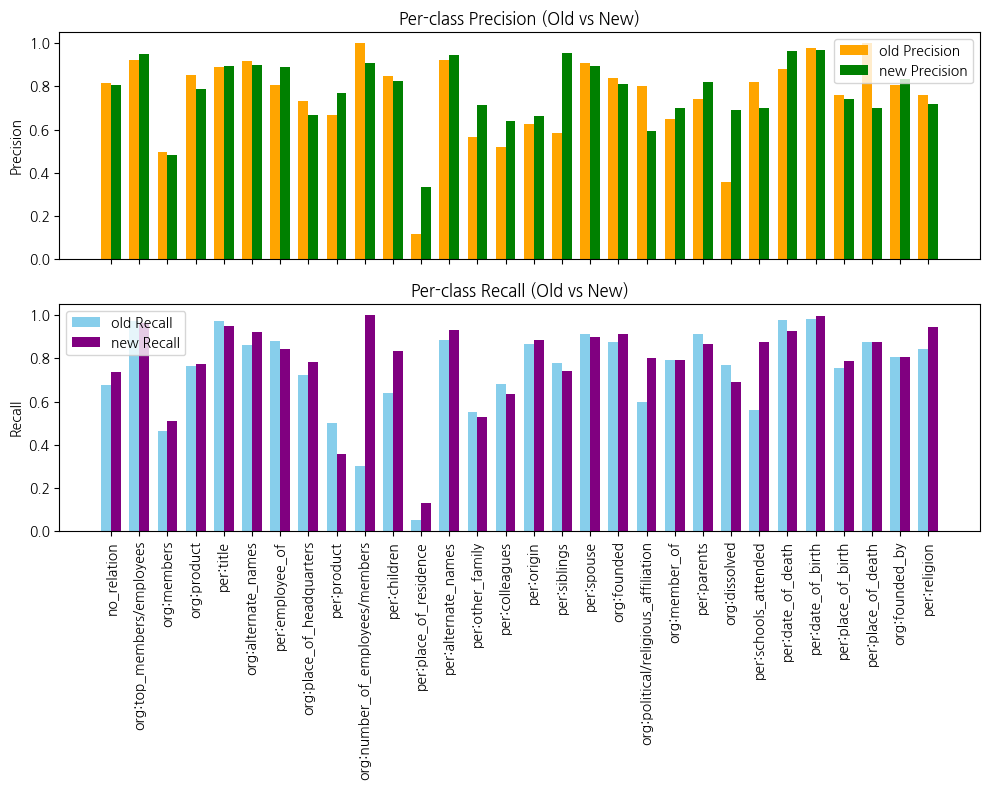

=== 희소 클래스 평균 Recall 상승폭 (New - Old) ===
  평균: 20.82% (n=5)
  per:religion: ΔRecall=10.53%
  per:schools_attended: ΔRecall=31.25%
  org:dissolved: ΔRecall=-7.69%
  org:number_of_employees/members: ΔRecall=70.00%
  per:place_of_death: ΔRecall=0.00%


In [74]:
compare_precision_recall_per_class(
    all_labels, old_preds, new_preds, list(label2id.keys()),
    rare_class_indices=rare_indices
)

In [75]:
def compare_false_negatives_fp(y_true, y_pred_old, y_pred_new, label_names):
    cm_old = confusion_matrix(y_true, y_pred_old, labels=range(len(label_names)))
    cm_new = confusion_matrix(y_true, y_pred_new, labels=range(len(label_names)))

    # FN: row sum - diagonal
    fn_old = cm_old.sum(axis=1) - np.diag(cm_old)
    fn_new = cm_new.sum(axis=1) - np.diag(cm_new)

    # FP: column sum - diagonal
    fp_old = cm_old.sum(axis=0) - np.diag(cm_old)
    fp_new = cm_new.sum(axis=0) - np.diag(cm_new)

    # 시각화
    idx = np.arange(len(label_names))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.subplot(211)
    plt.bar(idx - width/2, fn_old, width=width, color='red', label="Old FN")
    plt.bar(idx + width/2, fn_new, width=width, color='pink', label="New FN")
    plt.ylabel("FN Count")
    plt.title("False Negatives per Class (Old vs. New)")
    #plt.xticks(idx, label_names, rotation=90)
    plt.legend()

    plt.subplot(212)
    plt.bar(idx - width/2, fp_old, width=width, color='blue', label="Old FP")
    plt.bar(idx + width/2, fp_new, width=width, color='cyan', label="New FP")
    plt.ylabel("FP Count")
    plt.title("False Positives per Class (Old vs. New)")
    plt.xticks(idx, label_names, rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

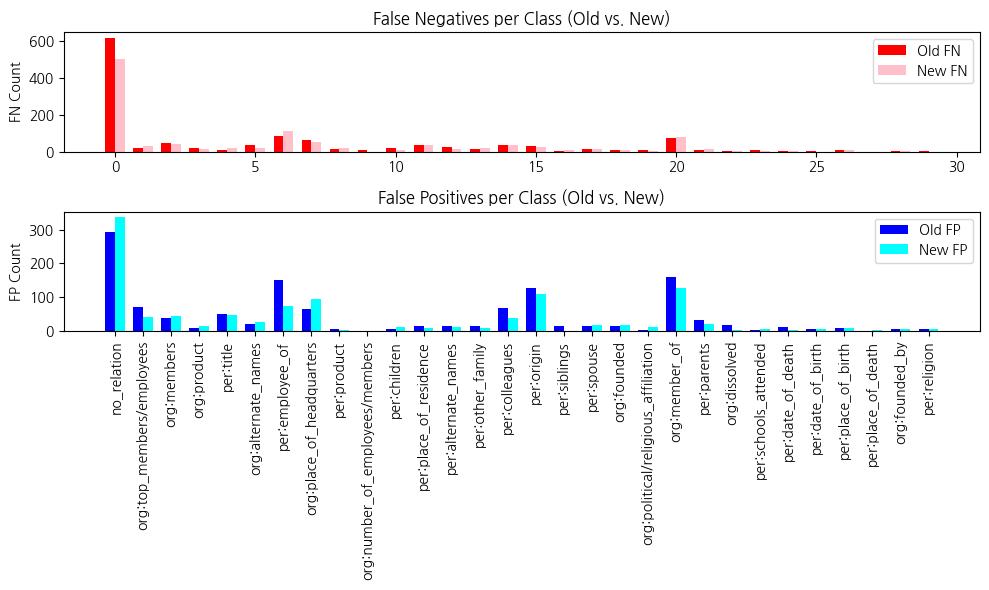

In [76]:
compare_false_negatives_fp(
    all_labels, old_preds, new_preds, list(label2id.keys()))

### 3.5 Attention 결과 확인

In [91]:
dataloader_iter = iter(valid_loader)

In [92]:
batch = next(iter(dataloader_iter))
for k,v in batch.items():
    print(k, v.shape)

id torch.Size([16])
input_ids torch.Size([16, 128])
attention_mask torch.Size([16, 128])
labels torch.Size([16])
e1_start_idx torch.Size([16])
e1_end_idx torch.Size([16])
e2_start_idx torch.Size([16])
e2_end_idx torch.Size([16])


In [93]:
batch = {k: v.to(device) for k, v in batch.items()}

In [94]:
model.eval()

with torch.no_grad():
    batch.pop("id")
    logits, e1_weights, e2_weights = model(
        **batch,
        return_weights=True
    )

In [80]:
model.eval()

with torch.no_grad():
    batch.pop("id")
    logits, attentions = model(
        **batch,
        return_attentions=True
    )

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


### 3.5.1 attention heat map

In [81]:
def visualize_attention_heatmap(input_ids, attention_map, tokenizer, title="Attention Heatmap"):

    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    seq_len = len(tokens)

    plt.figure(figsize=(seq_len*0.4, seq_len*0.4))
    sns.heatmap(attention_map, annot=False, cmap="Blues",
                xticklabels=tokens, yticklabels=tokens, square=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

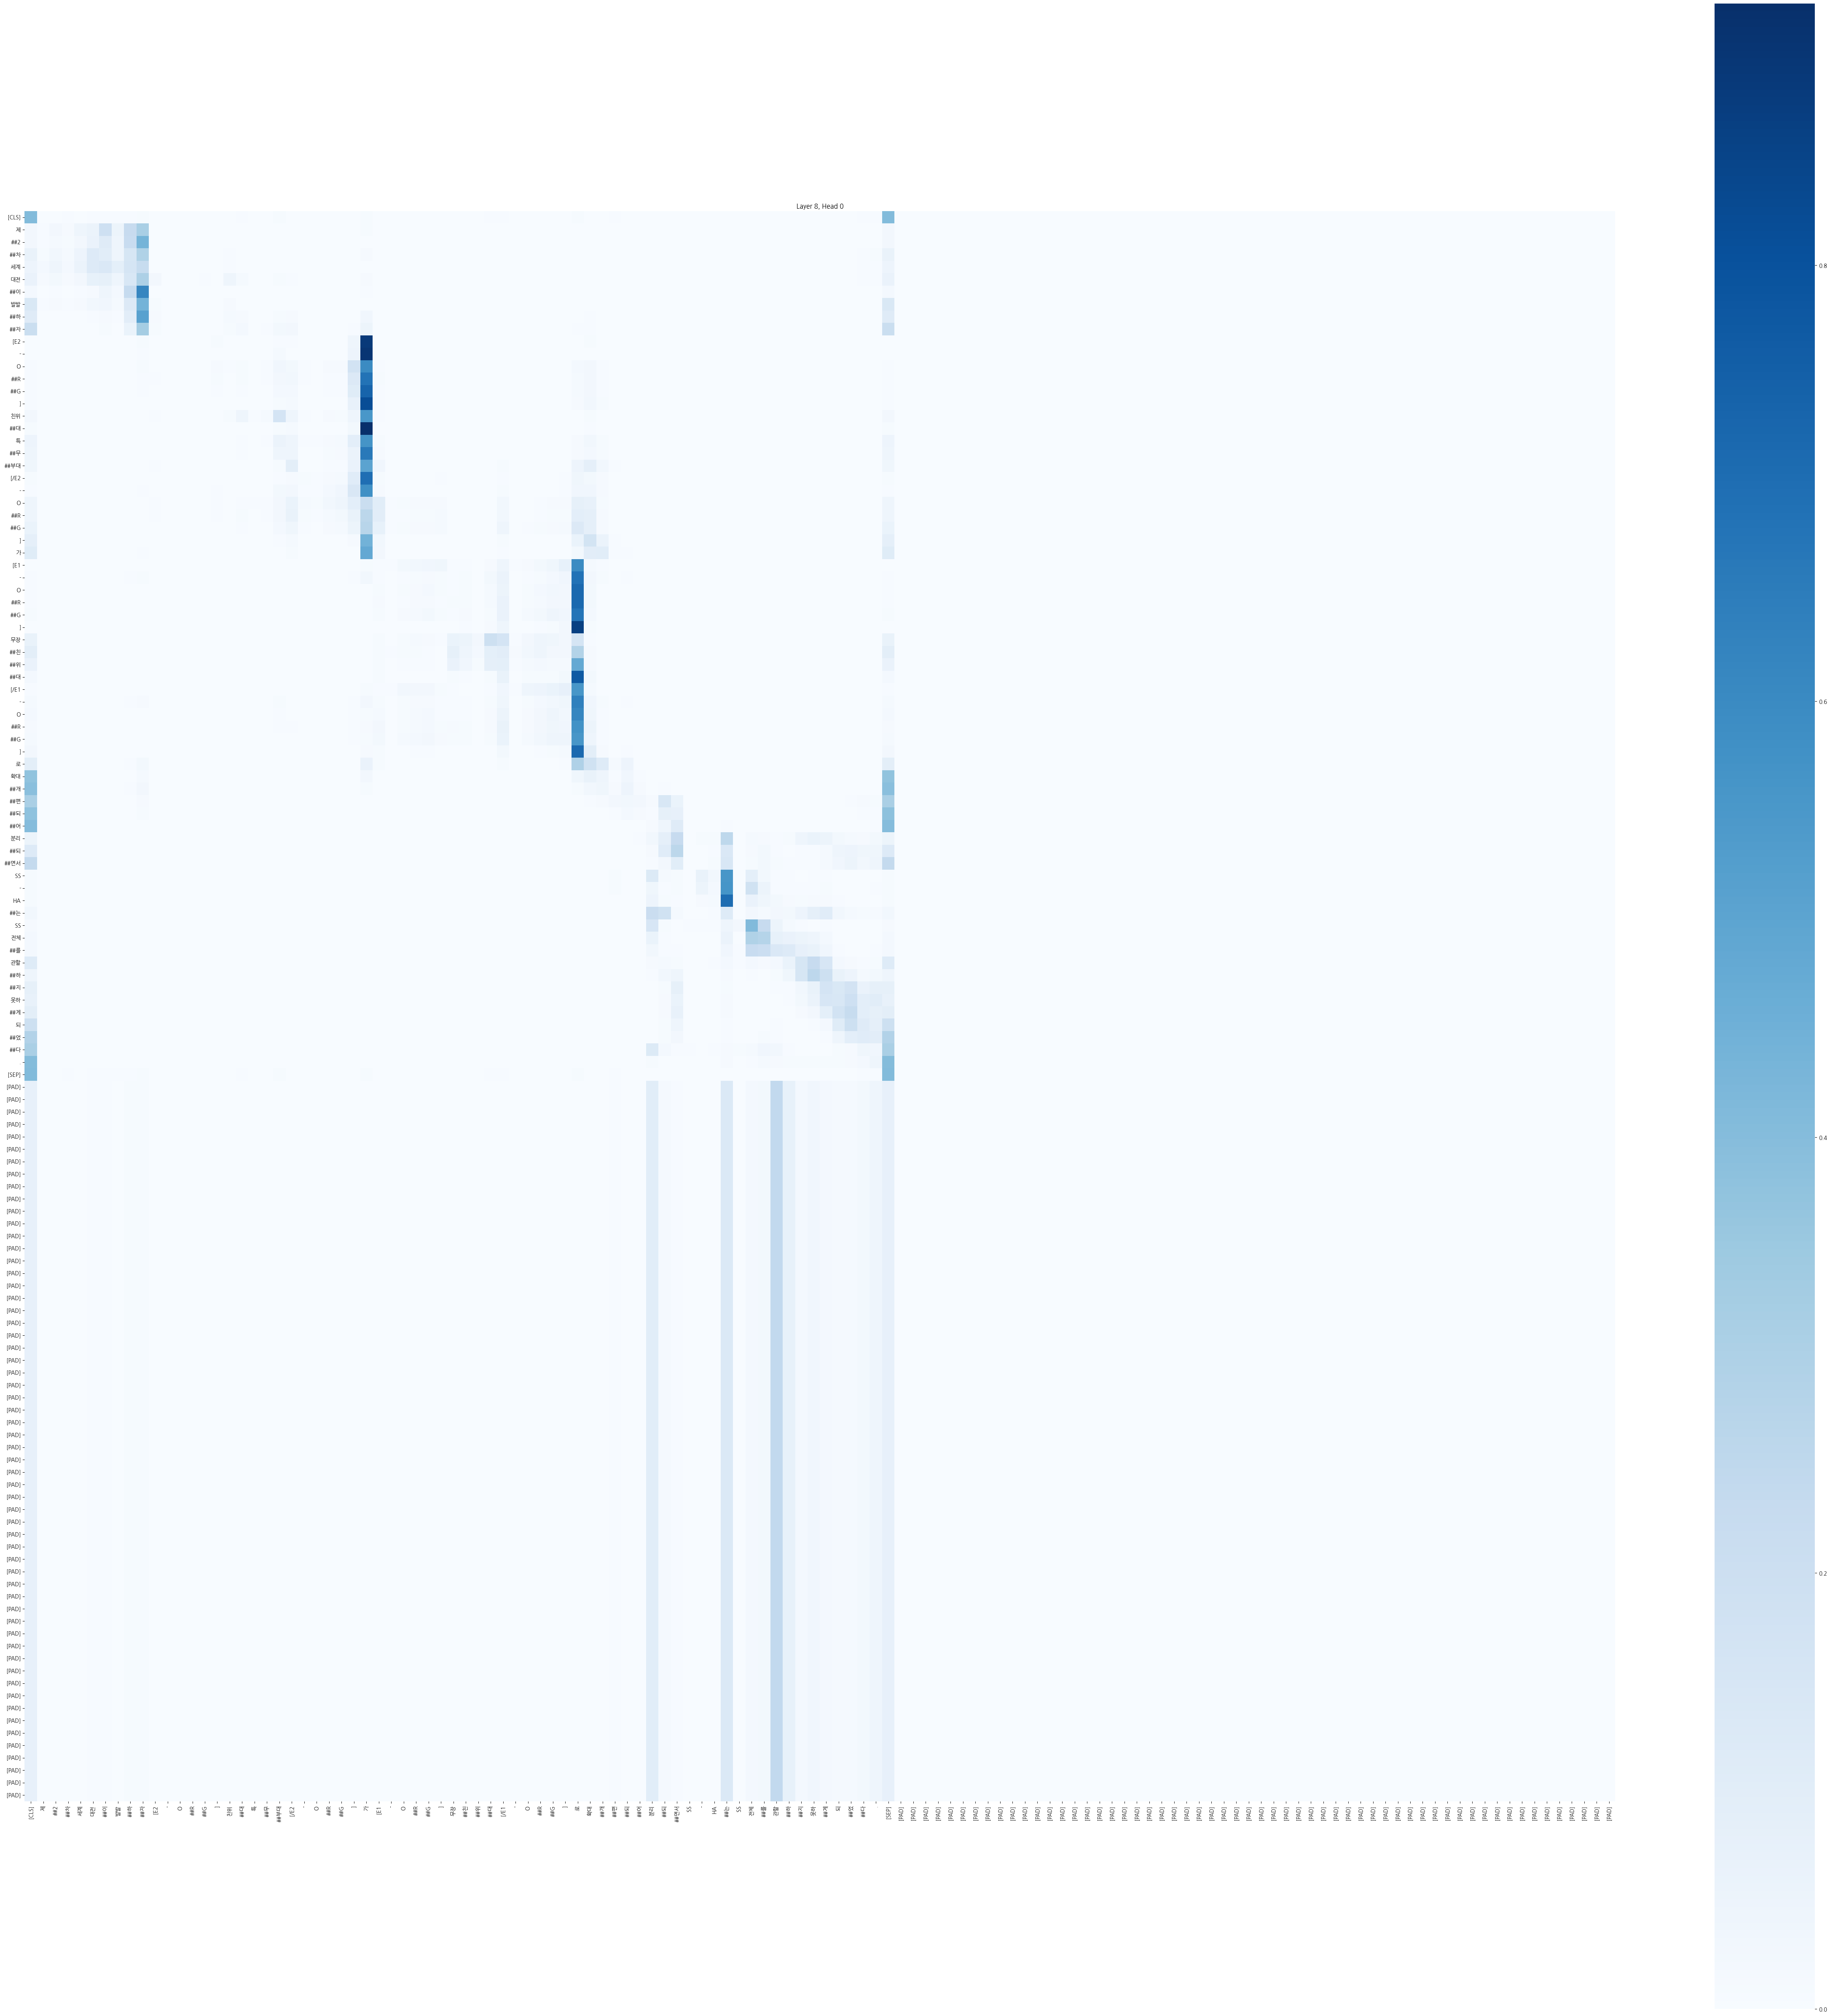

In [83]:
tokenizer = valid_dataset.tokenizer

layer_idx = 8
head_idx = 0

attn_map = attentions[layer_idx][0, head_idx]

input_ids_arr = batch["input_ids"][0].cpu().numpy()
attn_map_arr = attn_map.cpu().numpy()

visualize_attention_heatmap(input_ids_arr, attn_map_arr, tokenizer,
    title=f"Layer {layer_idx}, Head {head_idx}")

### 3.5.2 내부 토큰 attention 분석

In [95]:
def visualize_span_attention_tokens(tokens, attn_weights, title="Entity Span Attention"):

    if isinstance(attn_weights, torch.Tensor):
        attn_weights = attn_weights.numpy()

    span_length = len(tokens)

    plt.figure(figsize=(max(span_length*0.5, 5), 4))
    sns.barplot(x=tokens, y=attn_weights, color="purple")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.ylabel("Attention Weight")
    plt.tight_layout()
    plt.show()

In [ ]:
#best_model_20241225_072311_931795

In [96]:
i = 9
e1_w = e1_weights[i]
e2_w = e2_weights[i]
input_ids_i = batch["input_ids"][i]
tokens_all = valid_dataset.tokenizer.convert_ids_to_tokens(input_ids_i.cpu().numpy())

In [97]:
print(id2label[batch["labels"][i].item()])

org:place_of_headquarters


In [98]:
start1, end1 = batch["e1_start_idx"][i].item(), batch["e1_end_idx"][i].item()
e1_tokens = tokens_all[start1:end1+1]

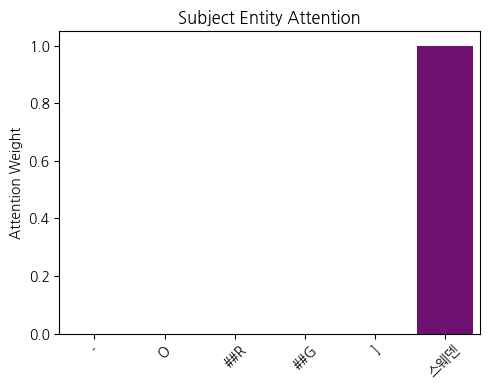

In [99]:
visualize_span_attention_tokens(e1_tokens, e1_w, title="Subject Entity Attention")

In [100]:
start2, end2 = batch["e2_start_idx"][i].item(), batch["e2_end_idx"][i].item()
e2_tokens = tokens_all[start2:end2+1]

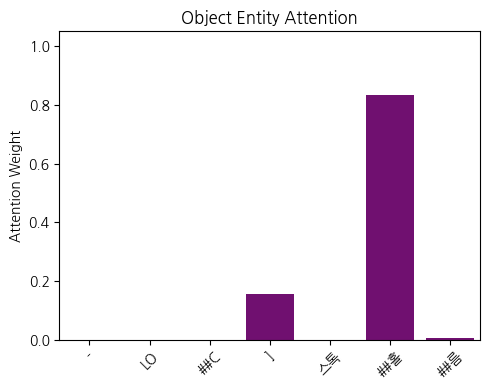

In [101]:
visualize_span_attention_tokens(e2_tokens, e2_w, title="Object Entity Attention")